voltage 40.0V
voltage 42.0V
voltage 44.0V
voltage 46.0V
voltage 48.0V
voltage 50.0V
voltage 52.0V


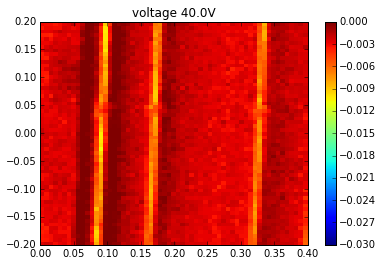

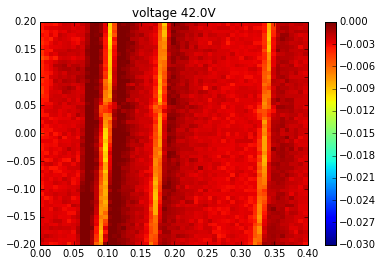

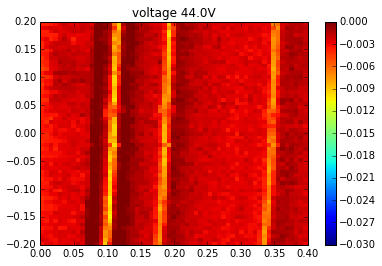

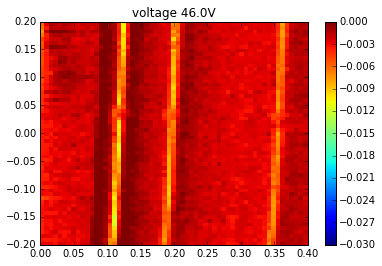

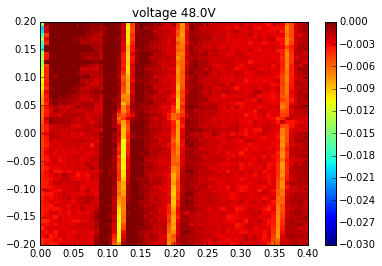

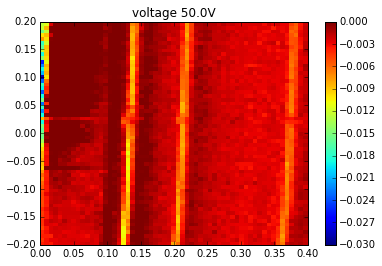

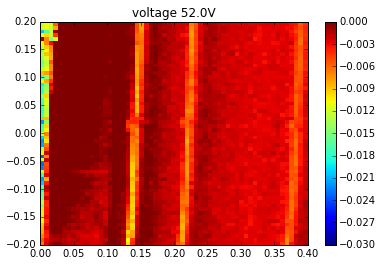

In [19]:
import matplotlib.pyplot as plt

import numpy as np
%matplotlib inline


# add additional path to import scripts used in gui
import sys
sys.path.append('C:/Users/Experiment/PycharmProjects/PythonLab')
from functions.save_array_to_disk import *
import functions.ScanPhotodiode_DAQ as GalvoScan
import hardware_modules.PiezoController as pc
import functions.tracking as trk

# set variables =============================================
# ===========================================================

axis = 'X'

rio_initial = {
        "xo": 0.2, 'yo': 0,
        "dx": 0.4, 'dy': 0.4,
        'xPts': 60, 'yPts': 60
    }

clim_min, clim_max = -0.03, 0

dirpath = 'Z:/Lab/Cantilever/Measurements/150526_Silicon_nitride_with_1um_pads/Box_c4_r3_ScanFocus_Beam_6/'

tag = 'Si3Ni4_withPads'


# run script =============================================
# ===========================================================

xVmin,xVmax,xPts,yVmin,yVmax,yPts = trk.rio_to_galvoparameter(rio_initial)
timePerPt = 0.001



voltages = np.arange(40,53,2)

#run script =================================================
# ===========================================================
X, Y = np.meshgrid( np.linspace(xVmin,xVmax,xPts),  np.linspace(yVmin,yVmax,yPts))

for counter, voltage in enumerate(voltages):
    
    print 'voltage {:0.1f}V'.format(voltage)
    # set focus
    xController = pc.MDT693A('X')
    xController.setVoltage(voltage)

    # acquire data
    scanner = GalvoScan.ScanNV(xVmin,xVmax,xPts,yVmin,yVmax,yPts,timePerPt, canvas = None)
    image_data = scanner.scan()



    # plot image
    fig = plt.figure()

    p = plt.pcolor(X, Y, image_data)
    # p = plt.imshow(image_data, interpolation="nearest")
    plt.colorbar()
    p.set_clim(clim_min, clim_max)
    plt.xlim([xVmin, xVmax])
    plt.ylim([yVmin, yVmax])
    plt.title('voltage {:0.1f}V'.format(voltage))
    # save image and data
#     save_image_and_data(fig, imageData, dirpath, '{:s}_V_{:02d}'.format(tag, voltage))

In [20]:
xController.setVoltage(46)

# stuff not finished!!!

In [6]:
import matplotlib.pyplot as plt

import numpy as np
%matplotlib inline


# add additional path to import scripts used in gui
import sys
sys.path.append('C:/Users/Experiment/PycharmProjects/PythonLab')
from functions.save_array_to_disk import *
import functions.ScanPhotodiode_DAQ as GalvoScan
import hardware_modules.PiezoController as pc
import functions.tracking as trk

# set variables =============================================
# ===========================================================

axis = 'X'

rio_initial = {
        "xo": 0, 'yo': 0,
        "dx": 0.8, 'dy': 0.8,
        'xPts': 120, 'yPts': 120
    }

clim_min, clim_max = -0.03, 0

dirpath = 'Z:/Lab/Cantilever/Measurements/150526_Silicon_nitride_with_1um_pads/Box_c4_r3_ScanFocus_Beam_6/'

tag = 'Si3Ni4_withPads'


# run script =============================================
# ===========================================================

xVmin,xVmax,xPts,yVmin,yVmax,yPts = trk.rio_to_galvoparameter(rio_initial)
timePerPt = 0.001



voltages = np.arange(50,70,2)

#run script =================================================
# ===========================================================
X, Y = np.meshgrid( np.linspace(xVmin,xVmax,xPts),  np.linspace(yVmin,yVmax,yPts))

for counter, voltage in enumerate(voltages):
    
    print 'voltage {:0.1f}V'.format(voltage)
    # set focus
    xController = pc.MDT693A('X')
    xController.setVoltage(voltage)

    # acquire data
    scanner = GalvoScan.ScanNV(xVmin,xVmax,xPts,yVmin,yVmax,yPts,timePerPt, canvas = None)
    image_data = scanner.scan()



    # plot image
    fig = plt.figure()

    p = plt.pcolor(X, Y, image_data)
    # p = plt.imshow(image_data, interpolation="nearest")
    plt.colorbar()
    p.set_clim(clim_min, clim_max)
    plt.xlim([xVmin, xVmax])
    plt.ylim([yVmin, yVmax])
    plt.title('voltage {:0.1f}V'.format(voltage))
    # save image and data
    save_image_and_data(fig, imageData, dirpath, '{:s}_V_{:02d}'.format(tag, voltage))